# Stock Price Prediction using Reddit News Headlines <br\>
## Byungsu Jung

In [45]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from subprocess import check_output
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D

## Data preparation

In [2]:
data = pd.read_csv('../Stock-Market-Prediction/stocknews/Combined_News_DJIA.csv')
train = data[data['Date'] <= '2015-01-01']
test = data[data['Date'] >= '2014-12-31']
# combine all the headlines into one string for each dates
# To lowercase
trainheadlines = []
testheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x).lower() for x in train.iloc[row,2:27]))
for row in range(0, len(test.index)):
    testheadlines.append(' '.join(str(x).lower() for x in test.iloc[row, 2:27]))

# Data not skwed.    
data.describe()

,Label
count,1989.000000
mean,0.535445
std,0.498867
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


Since I wish to predict up and down of stock price based on news headlines, <br\> 
I have assumed that a single word (i.e. unigram ) will not contain enough information of sentiment of word towards up and down of stock price. <br\>
First we will naively verify my claim by calculating accuracy score of each n-grams on LogisticRegression and use the best n-gram.

## Vectorizing using Tf-Idf and n-gram <br\>
### Purpose: To find the best n-gram for future use

In [3]:
# Use logistic regression to choose naively choose best n-gram
# We will also use Tf-idf in addition to n-gram to give a score to the words from headlines to identify which word or 
# words best represents a set of headlines, and use that score of each word or words as input to the

unigramVectorizer =  TfidfVectorizer( min_df=0.03, max_df=0.97, max_features = 200000, ngram_range = (1, 1))
bigramVectorizer =  TfidfVectorizer( min_df=0.03, max_df=0.97, max_features = 200000, ngram_range = (2, 2))

uniTrain = unigramVectorizer.fit_transform(trainheadlines)

biTrain = bigramVectorizer.fit_transform(trainheadlines)

uniTest = unigramVectorizer.transform(testheadlines)

biTest = bigramVectorizer.transform(testheadlines)
print("unigram train set shape: ", uniTrain.shape)
print("bigram train set shape: ", biTrain.shape)
print("unigram test set shape: ", uniTest.shape)
print("bigram test set shape: ", biTest.shape)

unigram train set shape:  (1611, 1952)
bigram train set shape:  (1611, 657)
unigram test set shape:  (379, 1952)
bigram test set shape:  (379, 657)


In [6]:
biLogisticR = LogisticRegression()
uniLogisticR = LogisticRegression()
biLogisticR.fit(biTrain, train['Label'])
uniLogisticR.fit(uniTrain, train['Label'])
# Accuracy score of two
uni_accuracy = accuracy_score(test['Label'], uniLogisticR.predict(uniTest))
bi_accuracy = accuracy_score(test['Label'], biLogisticR.predict(biTest))
print("Unigram accuracy score: ", uni_accuracy)
print("Bigram accuracy score: ", bi_accuracy)

Unigram accuracy score:  0.46965699208443273
Bigram accuracy score:  0.5725593667546174


In [108]:
# show highest coefficient and corresponding feature
def head_tail(vectorizer, model):
    features = vectorizer.get_feature_names()
    coeff = list(model.coef_)[0]
    df = pd.DataFrame({"features": features,
                      "coefficient": coeff})
    df = df.sort_values('coefficient', ascending=False)
    result_df = pd.concat([df.head(), df.tail()])
    return result_df

In [109]:
head_tail(bigramVectorizer,biLogisticR)

,coefficient,features
411,1.264377,set to
31,1.259669,and other
391,1.216202,right to
276,1.166895,likely to
14,1.128663,after the
131,-1.098193,fire on
40,-1.128193,around the
366,-1.144952,phone hacking
597,-1.146688,up in
452,-1.393351,the country


Although, bigram had accuracy greater than random, the words(features) are not yet intuitive.<br\>
It looks like two word is better than one word, but still not enough to hold meaningful intuition. Let's try to combine uni, bi and tri.

In [281]:
trigramVectorizer = TfidfVectorizer(min_df=0.03, max_df=0.97, max_features = 200000, ngram_range = (1, 3))
triTrain = trigramVectorizer.fit_transform(trainheadlines)
triTest = trigramVectorizer.transform(testheadlines)
triLogisticR = LogisticRegression()
triLogisticR.fit(triTrain, train['Label'])
tri_accuracy = accuracy_score(test['Label'], triLogisticR.predict(triTest))
tri_accuracy

0.5171503957783641

In [195]:
head_tail(trigramVectorizer,triLogisticR)

,coefficient,features
411,1.264377,set to
31,1.259669,and other
391,1.216202,right to
276,1.166895,likely to
14,1.128663,after the
131,-1.098193,fire on
40,-1.128193,around the
366,-1.144952,phone hacking
597,-1.146688,up in
452,-1.393351,the country


With the results above, we procede our stock price up and down prediction with **bi-gram** tf_idf

### Logisitic regression with bigram


Previously, We already used Logistic Regression with bi-gram without any hyperparameter tuning. <br\>
The follwoing is confusion matrix with accuracy score.

In [282]:
print("Bigram accuracy score: ", bi_accuracy)
confusion_matrix(test['Label'],biLogisticR.predict(biTest))

Bigram accuracy score:  0.5725593667546174


array([[ 73, 114],
       [ 48, 144]], dtype=int64)

In [ ]:
plt.matshow()

### Hyperparameter tunig on Test data(No validation set) <br\>


best_c:  0.4910000000000003
best_acc:  0.5883905013192612
best_model:  LogisticRegression(C=0.4910000000000003, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


array([[ 56, 131],
       [ 25, 167]], dtype=int64)

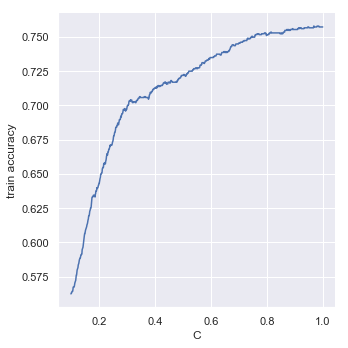

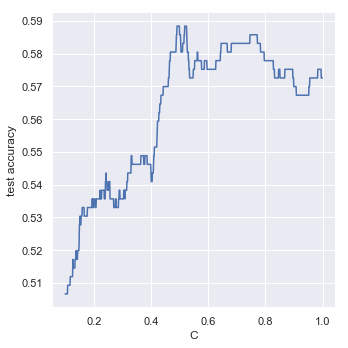

In [293]:
sns.set()
best_c = 0
best_acc = 0
best_model = None
data_acc = []
for i in np.arange(0.1, 1.0, 0.001):
  model = LogisticRegression(C = i)
  model.fit(biTrain, train['Label'])
  
  y_train_pred = model.predict(biTrain)
  train_acc = accuracy_score(train['Label'], y_train_pred)
  
  y_test_pred = model.predict(biTest)
  test_acc = accuracy_score(test['Label'], y_test_pred)
  
  data_acc.append({'C': i, 'train accuracy': train_acc, 
               'test accuracy': test_acc})
  if(test_acc > best_acc):
    best_acc = test_acc
    best_c = i
    best_model = model
data_acc = pd.DataFrame(data_acc)
sns.relplot(kind='line', x='C', y='train accuracy', data=data_acc)
sns.relplot(kind='line', x='C', y='test accuracy', data=data_acc)
print("best_c: ", best_c)
print("best_acc: ", best_acc)
print("best_model: ", best_model)
confusion_matrix(test['Label'],best_model.predict(biTest))

The result above is not quite regularized since it tested it's hyperparameters on test dataset, which make the model overfit to the test data. We will improve this by using cross validation and using validation set to test hyper parameters.

With the visualization best hyperparameter C, which is inverse of regularization strength. Now with this idea, let's peform GRID SEARCH of range from 0.4 to 0.6 for each 0.001 steps

In [290]:
grid_values = {'penalty': ['l2'],'C':np.arange(0.45, 0.55, 0.0001)}
grid_clf_acc = GridSearchCV(LogisticRegression(), param_grid = grid_values, verbose=1, cv=3)
grid_clf_acc.fit(biTrain, train['Label'])

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(biTest)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(test['Label'],y_pred_acc)))
print('Precision Score : ' + str(precision_score(test['Label'],y_pred_acc)))
print('Recall Score : ' + str(recall_score(test['Label'],y_pred_acc)))
print('F1 Score : ' + str(f1_score(test['Label'],y_pred_acc)))
print('best model: ' + str(grid_clf_acc.best_estimator_))
#Logistic Regression (Grid Search) Confusion matrix
confusion_matrix(test['Label'],y_pred_acc)

Fitting 3 folds for each of 1001 candidates, totalling 3003 fits
Accuracy Score : 0.575197889182058
Precision Score : 0.5543859649122806
Recall Score : 0.8229166666666666
F1 Score : 0.6624737945492662
best model: LogisticRegression(C=0.549499999999989, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


[Parallel(n_jobs=1)]: Done 3003 out of 3003 | elapsed:   17.5s finished


array([[ 60, 127],
       [ 34, 158]], dtype=int64)

We can see decrease in accuray by 0.01 but this is acceptable because this model is no longer overfit to test data. Now, let this logistic regression accuracy be our baseline for the accuracy of futher prediction by other classifiers. <br/>
Let's try Random Forest

### Base Random Forest Model

In [340]:
#Create a Gaussian Classifier
base_randomForest=RandomForestClassifier(n_estimators=100, random_state=1)
#Train the model using the training sets y_pred=base_randomForest.predict(X_test)
base_randomForest.fit(biTrain,train['Label'])
y_pred = base_randomForest.predict(biTest)
base_randomForest_acc = accuracy_score(test['Label'],y_pred)
print("Base RandomForest Accuracy: ", rf_clf_acc)

Base RandomForest Accuracy:  0.5224274406332454


Simple randomfrest classifier whoed 0.52 accuracy, which is still worse than our baseline.<br/> 
Let's do radom search to narrow down the hyperparameter space to improve the accuracy by hyperparameter tuning later in Grid Search.

### RandomSearch Grid

In [335]:
# Number of trees in random forest
n_estimators = np.arange(100, 1000, 100)
# Number of features to consider at /3every split
max_features = ['sqrt'] # auto is using all features, sqrt is usually good for classification
# Maximum number of levels in tree
max_depth = np.arange(10, 110, 10)
max_depth = np.append(max_depth,None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state': [1]}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], dtype=object),
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
 'random_state': [1]}


### RandomSearch

In [336]:
randomForest = RandomForestClassifier()
randomForest_random = RandomizedSearchCV(estimator = randomForest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, n_jobs = -1)
# Fit the random search model
randomForest_random.fit(biTrain, train['Label'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]), 'max_features': ['sqrt'], 'max_depth': array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], dtype=object), 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'random_state': [1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

### Let's checkout best estimator of RandomSearch

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy


In [341]:
# Best parameters from ransom search
print(randomForest_random.best_estimator_)
print(accuracy_score(test['Label'], randomForest_random.predict(biTest)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
0.5356200527704486


### Now let's use this values to tune hyperparameters more precisesly

### Grid Search Grid and Grid-Search

In [359]:
n_features = randomForest_random.best_estimator_.n_features_
max_feature_by3 = n_features // 3
param_grid = {
    'bootstrap': [True],
    'max_depth': np.arange(20, 51, 10),
    'max_features': ['sqrt', max_feature_by3],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': np.arange(300, 1000, 100),
    'random_state': [1]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1)
grid_search.fit(biTrain,train['Label'])

Fitting 3 folds for each of 882 candidates, totalling 2646 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 72.0min
[Parallel(n_jobs=-1)]: Done 2646 out of 2646 | elapsed: 81.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': array([30, 40, 50, 60, 70, 80, 90]), 'max_features': ['sqrt', 219], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': array([300, 400, 500, 600, 700, 800, 900]), 'random_state': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [363]:
n_features = randomForest_random.best_estimator_.n_features_
max_feature_by3 = n_features // 3
param_grid = {
    'bootstrap': [True],
    'max_depth': np.arange(20, 51, 10),
    'max_features': ['sqrt', max_feature_by3],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': np.arange(400, 600, 50),
    'random_state': [1]
}
# Instantiate the grid search model
grid_search2 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1)
grid_search2.fit(biTrain,train['Label'])

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 11.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': array([20, 30, 40, 50]), 'max_features': ['sqrt', 219], 'min_samples_leaf': [4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': array([400, 450, 500, 550]), 'random_state': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

# We will definitely compare accuray of models

In [361]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [362]:
accuracy_score(test['Label'],grid_search.predict(biTest))

0.5329815303430079

In [ ]:
from sklearn.tree import export_graphviz
import pydot
best_grid_search = grid_search.best
# Pull out one tree from the forest
tree = best_grid_search.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [92]:
epochs = np.arange(1, 10, 1)
dense = np.arange(8, 65, 8)
models = []
acc_result = []
for i in epochs:
    for j in dense:
        model = Sequential()
        model.add(Dense(j,input_shape=(biTrain.shape[1],)))
        model.add(Dropout(0.2))
        model.add(Activation('relu'))
        model.add(Dense(j))
        model.add(Dropout(0.2))
        model.add(Activation('relu'))
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.summary()
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['acc'])
        model.fit(biTrain,train['Label'],batch_size=32,epochs=i,verbose=1,validation_split=0.2)
        test_loss, test_acc = model.evaluate(biTest, test['Label'])
        models.append(model)
        acc_result.append({'epochs': i, 'dense': j, 'test accuracy': test_acc})


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_422 (Dense)            (None, 8)                 5264      
_________________________________________________________________
dropout_279 (Dropout)        (None, 8)                 0         
_________________________________________________________________
activation_411 (Activation)  (None, 8)                 0         
_________________________________________________________________
dense_423 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_280 (Dropout)        (None, 8)                 0         
_________________________________________________________________
activation_412 (Activation)  (None, 8)                 0         
_________________________________________________________________
dense_424 (Dense)            (None, 1)                 9         
__________

Train on 1288 samples, validate on 323 samples
Epoch 1/1
379/379 [==============================] - 0s 226us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_440 (Dense)            (None, 56)                36848     
_________________________________________________________________
dropout_291 (Dropout)        (None, 56)                0         
_________________________________________________________________
activation_429 (Activation)  (None, 56)                0         
_________________________________________________________________
dense_441 (Dense)            (None, 56)                3192      
_________________________________________________________________
dropout_292 (Dropout)        (None, 56)                0         
_________________________________________________________________
activation_430 (Activation)  (None, 56)                0         
____________________________

Train on 1288 samples, validate on 323 samples
Epoch 1/2
1288/1288 [==============================] - 12s 9ms/step - loss: 0.6908 - acc: 0.5342 - val_loss: 0.6894 - val_acc: 0.5511
Epoch 2/2
379/379 [==============================] - 0s 263us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_455 (Dense)            (None, 32)                21056     
_________________________________________________________________
dropout_301 (Dropout)        (None, 32)                0         
_________________________________________________________________
activation_444 (Activation)  (None, 32)                0         
_________________________________________________________________
dense_456 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_302 (Dropout)        (None, 32)                0         
__________________________

Train on 1288 samples, validate on 323 samples
Epoch 1/2
1288/1288 [==============================] - 14s 11ms/step - loss: 0.6922 - acc: 0.5225 - val_loss: 0.6883 - val_acc: 0.5511
Epoch 2/2
379/379 [==============================] - 0s 295us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_470 (Dense)            (None, 8)                 5264      
_________________________________________________________________
dropout_311 (Dropout)        (None, 8)                 0         
_________________________________________________________________
activation_459 (Activation)  (None, 8)                 0         
_________________________________________________________________
dense_471 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_312 (Dropout)        (None, 8)                 0         
_________________________

Train on 1288 samples, validate on 323 samples
Epoch 1/3
1288/1288 [==============================] - 13s 10ms/step - loss: 0.6919 - acc: 0.5287 - val_loss: 0.6885 - val_acc: 0.5511
Epoch 2/3
1288/1288 [==============================] - 1s 389us/step - loss: 0.6844 - acc: 0.5411 - val_loss: 0.6877 - val_acc: 0.5511
Epoch 3/3
379/379 [==============================] - 0s 245us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_485 (Dense)            (None, 48)                31584     
_________________________________________________________________
dropout_321 (Dropout)        (None, 48)                0         
_________________________________________________________________
activation_474 (Activation)  (None, 48)                0         
_________________________________________________________________
dense_486 (Dense)            (None, 48)                2352      
______________________

379/379 [==============================] - 0s 289us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_497 (Dense)            (None, 16)                10528     
_________________________________________________________________
dropout_329 (Dropout)        (None, 16)                0         
_________________________________________________________________
activation_486 (Activation)  (None, 16)                0         
_________________________________________________________________
dense_498 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_330 (Dropout)        (None, 16)                0         
_________________________________________________________________
activation_487 (Activation)  (None, 16)                0         
_________________________________________________________________
dense_499 (Dense)  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_509 (Dense)            (None, 48)                31584     
_________________________________________________________________
dropout_337 (Dropout)        (None, 48)                0         
_________________________________________________________________
activation_498 (Activation)  (None, 48)                0         
_________________________________________________________________
dense_510 (Dense)            (None, 48)                2352      
_________________________________________________________________
dropout_338 (Dropout)        (None, 48)                0         
_________________________________________________________________
activation_499 (Activation)  (None, 48)                0         
_________________________________________________________________
dense_511 (Dense)            (None, 1)                 49        
__________

379/379 [==============================] - 0s 242us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_521 (Dense)            (None, 16)                10528     
_________________________________________________________________
dropout_345 (Dropout)        (None, 16)                0         
_________________________________________________________________
activation_510 (Activation)  (None, 16)                0         
_________________________________________________________________
dense_522 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_346 (Dropout)        (None, 16)                0         
_________________________________________________________________
activation_511 (Activation)  (None, 16)                0         
_________________________________________________________________
dense_523 (Dense)  

1288/1288 [==============================] - 1s 413us/step - loss: 0.6863 - acc: 0.5497 - val_loss: 0.6887 - val_acc: 0.5511
Epoch 3/5
1288/1288 [==============================] - 1s 484us/step - loss: 0.6780 - acc: 0.5668 - val_loss: 0.6881 - val_acc: 0.5697
Epoch 4/5
1288/1288 [==============================] - 1s 513us/step - loss: 0.6569 - acc: 0.6498 - val_loss: 0.6874 - val_acc: 0.5511
Epoch 5/5
379/379 [==============================] - 0s 300us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_533 (Dense)            (None, 48)                31584     
_________________________________________________________________
dropout_353 (Dropout)        (None, 48)                0         
_________________________________________________________________
activation_522 (Activation)  (None, 48)                0         
_________________________________________________________________
dense_534 

Train on 1288 samples, validate on 323 samples
Epoch 1/6
1288/1288 [==============================] - 17s 13ms/step - loss: 0.6932 - acc: 0.4899 - val_loss: 0.6919 - val_acc: 0.5387
Epoch 2/6
1288/1288 [==============================] - 0s 337us/step - loss: 0.6902 - acc: 0.5505 - val_loss: 0.6903 - val_acc: 0.5387
Epoch 3/6
1288/1288 [==============================] - 0s 335us/step - loss: 0.6879 - acc: 0.5644 - val_loss: 0.6894 - val_acc: 0.5449
Epoch 4/6
1288/1288 [==============================] - 0s 338us/step - loss: 0.6854 - acc: 0.5745 - val_loss: 0.6888 - val_acc: 0.5449
Epoch 5/6
1288/1288 [==============================] - 0s 331us/step - loss: 0.6812 - acc: 0.5862 - val_loss: 0.6883 - val_acc: 0.5480
Epoch 6/6
379/379 [==============================] - 0s 295us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_545 (Dense)            (None, 16)                10528     
_____________

Train on 1288 samples, validate on 323 samples
Epoch 1/6
1288/1288 [==============================] - 18s 14ms/step - loss: 0.6916 - acc: 0.5241 - val_loss: 0.6895 - val_acc: 0.5480
Epoch 2/6
1288/1288 [==============================] - 1s 399us/step - loss: 0.6843 - acc: 0.5489 - val_loss: 0.6887 - val_acc: 0.5511
Epoch 3/6
1288/1288 [==============================] - 1s 430us/step - loss: 0.6761 - acc: 0.5551 - val_loss: 0.6871 - val_acc: 0.5542
Epoch 4/6
1288/1288 [==============================] - 1s 406us/step - loss: 0.6530 - acc: 0.6460 - val_loss: 0.6855 - val_acc: 0.5294
Epoch 5/6
1288/1288 [==============================] - 1s 420us/step - loss: 0.6062 - acc: 0.7500 - val_loss: 0.6942 - val_acc: 0.5356
Epoch 6/6
379/379 [==============================] - 0s 326us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_557 (Dense)            (None, 48)                31584     
_____________

Train on 1288 samples, validate on 323 samples
Epoch 1/7
1288/1288 [==============================] - 17s 13ms/step - loss: 0.6921 - acc: 0.5419 - val_loss: 0.6883 - val_acc: 0.5511
Epoch 2/7
1288/1288 [==============================] - 1s 390us/step - loss: 0.6883 - acc: 0.5411 - val_loss: 0.6874 - val_acc: 0.5511
Epoch 3/7
1288/1288 [==============================] - 0s 362us/step - loss: 0.6841 - acc: 0.5474 - val_loss: 0.6866 - val_acc: 0.5511
Epoch 4/7
1288/1288 [==============================] - 0s 356us/step - loss: 0.6781 - acc: 0.5722 - val_loss: 0.6859 - val_acc: 0.5480
Epoch 5/7
1288/1288 [==============================] - 0s 372us/step - loss: 0.6691 - acc: 0.5916 - val_loss: 0.6857 - val_acc: 0.5418
Epoch 6/7
1288/1288 [==============================] - 0s 365us/step - loss: 0.6585 - acc: 0.6196 - val_loss: 0.6859 - val_acc: 0.5542
Epoch 7/7
379/379 [==============================] - 0s 297us/step
_________________________________________________________________
Layer (typ

379/379 [==============================] - 0s 305us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_578 (Dense)            (None, 40)                26320     
_________________________________________________________________
dropout_383 (Dropout)        (None, 40)                0         
_________________________________________________________________
activation_567 (Activation)  (None, 40)                0         
_________________________________________________________________
dense_579 (Dense)            (None, 40)                1640      
_________________________________________________________________
dropout_384 (Dropout)        (None, 40)                0         
_________________________________________________________________
activation_568 (Activation)  (None, 40)                0         
_________________________________________________________________
dense_580 (Dense)  

Train on 1288 samples, validate on 323 samples
Epoch 1/7
1288/1288 [==============================] - 17s 14ms/step - loss: 0.6914 - acc: 0.5427 - val_loss: 0.6886 - val_acc: 0.5511
Epoch 2/7
1288/1288 [==============================] - 1s 517us/step - loss: 0.6832 - acc: 0.5411 - val_loss: 0.6872 - val_acc: 0.5511
Epoch 3/7
1288/1288 [==============================] - 1s 493us/step - loss: 0.6689 - acc: 0.5877 - val_loss: 0.6867 - val_acc: 0.5573
Epoch 4/7
1288/1288 [==============================] - 1s 495us/step - loss: 0.6265 - acc: 0.6941 - val_loss: 0.6909 - val_acc: 0.5108
Epoch 5/7
1288/1288 [==============================] - 1s 501us/step - loss: 0.5550 - acc: 0.7710 - val_loss: 0.7248 - val_acc: 0.5232
Epoch 6/7
1288/1288 [==============================] - 1s 492us/step - loss: 0.4504 - acc: 0.8385 - val_loss: 0.7892 - val_acc: 0.5263
Epoch 7/7
379/379 [==============================] - 0s 266us/step
_________________________________________________________________
Layer (typ

1288/1288 [==============================] - 0s 387us/step - loss: 0.6228 - acc: 0.7057 - val_loss: 0.6890 - val_acc: 0.5201
Epoch 6/8
1288/1288 [==============================] - 0s 376us/step - loss: 0.5836 - acc: 0.7446 - val_loss: 0.6972 - val_acc: 0.5015
Epoch 7/8
1288/1288 [==============================] - 0s 359us/step - loss: 0.5335 - acc: 0.7880 - val_loss: 0.7234 - val_acc: 0.5077
Epoch 8/8
379/379 [==============================] - 0s 271us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_599 (Dense)            (None, 32)                21056     
_________________________________________________________________
dropout_397 (Dropout)        (None, 32)                0         
_________________________________________________________________
activation_588 (Activation)  (None, 32)                0         
_________________________________________________________________
dense_600 

379/379 [==============================] - 0s 266us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_608 (Dense)            (None, 56)                36848     
_________________________________________________________________
dropout_403 (Dropout)        (None, 56)                0         
_________________________________________________________________
activation_597 (Activation)  (None, 56)                0         
_________________________________________________________________
dense_609 (Dense)            (None, 56)                3192      
_________________________________________________________________
dropout_404 (Dropout)        (None, 56)                0         
_________________________________________________________________
activation_598 (Activation)  (None, 56)                0         
_________________________________________________________________
dense_610 (Dense)  

Train on 1288 samples, validate on 323 samples
Epoch 1/9
1288/1288 [==============================] - 19s 14ms/step - loss: 0.6925 - acc: 0.5334 - val_loss: 0.6908 - val_acc: 0.5511
Epoch 2/9
1288/1288 [==============================] - 0s 369us/step - loss: 0.6873 - acc: 0.5380 - val_loss: 0.6892 - val_acc: 0.5511
Epoch 3/9
1288/1288 [==============================] - 0s 378us/step - loss: 0.6830 - acc: 0.5458 - val_loss: 0.6882 - val_acc: 0.5511
Epoch 4/9
1288/1288 [==============================] - 0s 382us/step - loss: 0.6763 - acc: 0.5598 - val_loss: 0.6877 - val_acc: 0.5604
Epoch 5/9
1288/1288 [==============================] - 0s 378us/step - loss: 0.6654 - acc: 0.5963 - val_loss: 0.6868 - val_acc: 0.5604
Epoch 6/9
1288/1288 [==============================] - 0s 370us/step - loss: 0.6428 - acc: 0.6545 - val_loss: 0.6894 - val_acc: 0.5387
Epoch 7/9
1288/1288 [==============================] - 1s 415us/step - loss: 0.6138 - acc: 0.7120 - val_loss: 0.6918 - val_acc: 0.5418
Epoch 8/

1288/1288 [==============================] - 20s 16ms/step - loss: 0.6918 - acc: 0.5264 - val_loss: 0.6888 - val_acc: 0.5511
Epoch 2/9
1288/1288 [==============================] - 1s 486us/step - loss: 0.6842 - acc: 0.5404 - val_loss: 0.6877 - val_acc: 0.5511
Epoch 3/9
1288/1288 [==============================] - 1s 488us/step - loss: 0.6733 - acc: 0.5691 - val_loss: 0.6879 - val_acc: 0.5480
Epoch 4/9
1288/1288 [==============================] - 1s 486us/step - loss: 0.6486 - acc: 0.6110 - val_loss: 0.6880 - val_acc: 0.5263
Epoch 5/9
1288/1288 [==============================] - 1s 476us/step - loss: 0.6054 - acc: 0.7158 - val_loss: 0.6974 - val_acc: 0.5387
Epoch 6/9
1288/1288 [==============================] - 1s 490us/step - loss: 0.5330 - acc: 0.7919 - val_loss: 0.7354 - val_acc: 0.5294
Epoch 7/9
1288/1288 [==============================] - 1s 471us/step - loss: 0.4443 - acc: 0.8385 - val_loss: 0.7951 - val_acc: 0.5108
Epoch 8/9
1288/1288 [==============================] - 1s 471us/s

1288/1288 [==============================] - 20s 15ms/step - loss: 0.6930 - acc: 0.5202 - val_loss: 0.6888 - val_acc: 0.5511
Epoch 2/9
1288/1288 [==============================] - 1s 609us/step - loss: 0.6826 - acc: 0.5404 - val_loss: 0.6876 - val_acc: 0.5511
Epoch 3/9
1288/1288 [==============================] - 1s 604us/step - loss: 0.6731 - acc: 0.5606 - val_loss: 0.6850 - val_acc: 0.5635
Epoch 4/9
1288/1288 [==============================] - 1s 594us/step - loss: 0.6431 - acc: 0.6530 - val_loss: 0.6887 - val_acc: 0.5418
Epoch 5/9
1288/1288 [==============================] - 1s 593us/step - loss: 0.5715 - acc: 0.7547 - val_loss: 0.7113 - val_acc: 0.5666
Epoch 6/9
1288/1288 [==============================] - 1s 656us/step - loss: 0.4809 - acc: 0.7974 - val_loss: 0.7690 - val_acc: 0.5263
Epoch 7/9
1288/1288 [==============================] - 1s 776us/step - loss: 0.3704 - acc: 0.8556 - val_loss: 0.8663 - val_acc: 0.5170
Epoch 8/9
1288/1288 [==============================] - 1s 859us/s

In [95]:
acc_result[acc_result['test accuracy'] == max(acc_result['test accuracy'])]

,dense,epochs,test accuracy
46,56,6,0.575198


In [97]:
acc_result

,dense,epochs,test accuracy
0,8,1,0.503958
1,16,1,0.501319
2,24,1,0.506596
3,32,1,0.506596
4,40,1,0.506596
5,48,1,0.506596
6,56,1,0.503958
7,64,1,0.506596
8,8,2,0.532982
9,16,2,0.506596


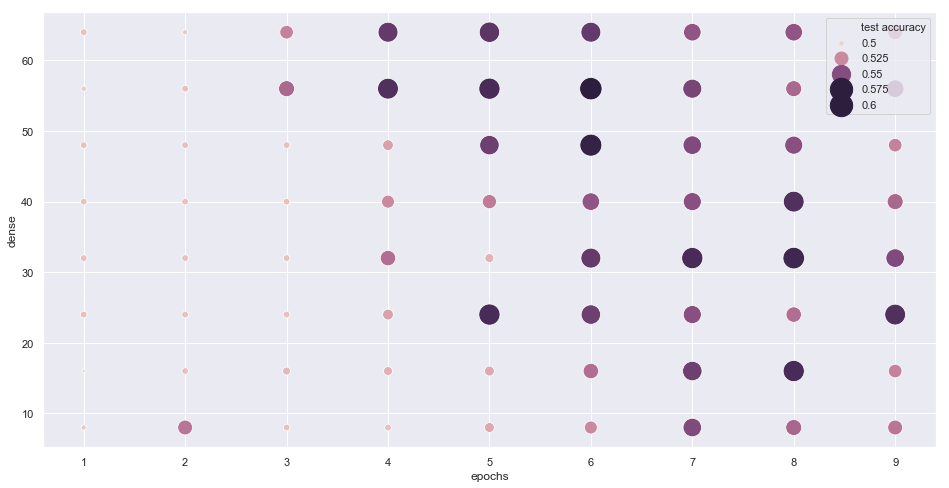

In [107]:
acc_result = pd.DataFrame(acc_result)
sns.set(rc={'figure.figsize':(16, 8)})
sns.scatterplot(x='epochs', y='dense', hue="test accuracy", size="test accuracy",data=acc_result, sizes=(10, 500))
